In [1]:
!pip install category_encoders
!pip install fuzzywuzzy

     |████████████████████████████████| 81kB 4.1MB/s 


In [2]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import warnings
from fuzzywuzzy import fuzz
import re

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Feature Engineering

In [4]:
test = pd.read_csv('/content/drive/MyDrive/input/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 1) 카테고리에 대한 처리

In [5]:
categories = pd.read_csv('/content/drive/MyDrive/input/categories.csv')
pd.DataFrame(categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


특수 문자 전 까지의 단어를 group이란 feature로 추가해주었다

In [6]:
# 카테고리를 이름에 따라 그룹으로 분류하고, 이를 인코딩하여 나타낸다.
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
categories['group_id']  = le.fit_transform(categories.group_name.values)

### 2) Item에 대한 처리

In [7]:
items = pd.read_csv('/content/drive/MyDrive/input/items.csv')
items.head(20)

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D
5,5,40,*** NEW AMERICAN GRAPHICS (UNI) D
6,6,40,*** BLOCK ON THE GATES (UNI) D
7,7,40,*** SHOCK AT DOOR-2 (UNI) D
8,8,40,*** TEA WITH MUSSOLINI D
9,9,40,*** SHUGARLEND EXPRESS (UNI) D


In [8]:
# 아이템 이름의 길이를 feature로 추가
items['item_name_len'] = items["item_name"].apply(len)

# 아이템 이름을 clean(lowercase 처리 및 특수문자 처리)
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
      
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')

# clean한 아이템의 이름을 feature로 추가
items['item_name_cleaned_len'] = items["item_name_no_space"].apply(len)

# item 이름의 앞 11글자를 feature로
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]

del items['item_name_no_space']

items.head(5)

,item_id,category_id,item_name,item_name_len,item_name_cleaned_len,item_name_first11
0,0,40,power happiness plast,38,19,powerhappin
1,1,76,abbyy finereader 12 professional edition ful...,69,56,abbyyfinere
2,2,40,glory glory unv,37,13,glorygloryu
3,3,40,blue wave univ,22,12,bluewaveuni
4,4,40,box glass,17,8,boxglass


In [9]:
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

items = items.join(categories.set_index('category_id'), on='category_id')

이름이 같은데 아이디가 중복되는 item들이 존재한다. 
<br>복수의 id가 존재하는 경우 <br>
1) 둘다 test set에 존재하는 id라면 아무것도 하지 않는다. <br>
2) 둘 중 하나만 test set에 존재하면 그 아이디로 reassign 해준다. <br>
3) 둘다 test set에 없는 경우 두번째 id로 reassign 해준다.

In [10]:
duplicated_items = items[(items.duplicated(subset=['item_name','category_id'],keep=False))] 
duplicated_items['in_test'] = duplicated_items.item_id.isin(test.item_id.unique())
#duplicated_items을 item_name으로 그룹을 지은 다음 item_id의 첫번째 값과 마지막값, in_test의 첫번째 값과 마지막 값을 의미한다.
duplicated_items = duplicated_items.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']}) 

In [11]:
duplicated_items.head()

item_id        in_test       
                                          first   last   first   last
item_name                                                            
                                             32  10725    True  False
      all   ballads     80                 7507   7508    True   True
      art   electro swing     digipack     7453   7454   False  False
      best   lounge     4cd  digibook      7456   7457   False  False
      instrumental hits best               7516   7517   False  False

In [12]:
duplicated_items = duplicated_items[(duplicated_items[('in_test', 'first')]==False) | (duplicated_items[('in_test', 'last')]==False)] 
temp = duplicated_items[duplicated_items[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
temp = duplicated_items[duplicated_items[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

fuzzywuzzy를 이용하여 이름이 비슷한 아이템들을 그룹으로 묶어 feature 추가

In [13]:
def item_name_groups(items, sim_thresh=60):
    def partialcompare(s):
        return fuzz.partial_ratio(s["str1"], s["str2"])

    
    def strip_brackets(string):
        string = re.sub(r"\(.*?\)", "", string)
        string = re.sub(r"\[.*?\]", "", string)
        return string

    items = items.copy()
    items["str1"] = items.item_name.apply(strip_brackets)
    items["str2"] = np.concatenate((items["str1"].to_numpy()[1:], np.array([""])))
    items["sim_str"] = items.apply(partialcompare, axis=1)
    
    group = 0
    for i in range(items.shape[0]):
        items.loc[i, "item_name_group"] = group
        if items.loc[i, "sim_str"] < sim_thresh:
            group += 1
    items = items.drop(columns=["str1", "str2", "sim_str"])
    return items

In [14]:
items = item_name_groups(items)

items["item_name_group"] = items["item_name_group"].apply(str)
items["item_name_group"] = items["item_name_group"].factorize()[0]

items.query("item_id >3000").head(5)

,item_id,category_id,item_name,item_name_len,item_name_cleaned_len,item_name_first11,category_name,group_name,group_id,item_name_group
3001,3001,76,drweb security space rs pc 12 months promot...,144,102,3406,Programs - For home and office (Digit),Programs,16,1063
3002,3002,76,drweb security space pc fault 12 months pc ...,64,49,3406,Programs - For home and office (Digit),Programs,16,1063
3003,3003,76,drweb security space rs pc 24 months pc di...,61,46,3406,Programs - For home and office (Digit),Programs,16,1063
3004,3004,76,drweb security space rs pc 24 months extensi...,71,55,3406,Programs - For home and office (Digit),Programs,16,1063
3005,3005,76,drweb security space rs pc months pc dig...,60,44,3406,Programs - For home and office (Digit),Programs,16,1063


### 3) Sales information에 대한 처리

- 필요 없는 정보 삭제
- outlier 제거
- 중복 shop에 대한 처리

In [15]:
sales = pd.read_csv('/content/drive/MyDrive/input/sales_train.csv')
# 앞서 만들었던 중복 item_id를 처리하기 위한 map으로 중복되는 item_id들을 처리해준다.
sales = (sales.replace({ 
    'item_id':item_map #fixing duplicate item id's  
    })    
)
# test에 있는 shop들만 선택
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

# outlier 제거
sales = sales[(sales.item_price < 50000 )& (sales.item_cnt_day < 1000)& (sales.item_price >-1)]

# 중복 shop에 대한 처리
sales.loc[sales['shop_id']==0,'shop_id']=57
test.loc[test['shop_id']==0,'shop_id']=57

sales.loc[sales['shop_id']==1,'shop_id']=58
test.loc[test['shop_id']==1,'shop_id']=58

sales.loc[sales['shop_id']==10,'shop_id']=11
test.loc[test['shop_id']==10,'shop_id']=11

sales.loc[sales['shop_id']==40,'shop_id']=39
test.loc[test['shop_id']==40,'shop_id']=39

날짜에 관한 feature 추가
- item이 처음 팔린 날: 'first_sale_day'
- month, year, first day of month 
- 월별 판매량

In [16]:
sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.weekday

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [17]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
#이렇게 본다는 것은 shop_id와 weekday를 기준으로 item_cnt_day의 합을 본다. 따라서 특정 가게의 특정 요일의 item_cnt_day의 합을 볼 수 있는 것이다. 

temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']

#weekday를 index로 하고 dates와 합쳤다. 
dates = dates.join(temp.set_index('weekday'), on='weekday')
# first_day_month: 2013-01-01를 기준으로 해당달의 첫번째 날의 지난날수
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

In [18]:
# date_block_num, shop_id, item_id를 기준으로 item_cnt_day를 sum, revenue를 sum
# 즉 특정달, 특정 상점, 특정 아이템을 기준으로 아이템 판매량을 item_count, 수입을 revenue로 지정
sales = (sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum', 'revenue':'sum','first_sale_day':'first'}).reset_index()
     .rename(columns={'item_cnt_day':'item_count'})
)

sales.head(10)

,date_block_num,shop_id,item_id,item_count,revenue,first_sale_day
0,0,2,27,1.0,2499.0,2
1,0,2,33,1.0,499.0,2
2,0,2,317,1.0,299.0,4
3,0,2,438,1.0,299.0,19
4,0,2,471,2.0,798.0,3
5,0,2,481,1.0,330.0,2
6,0,2,482,1.0,3300.0,4
7,0,2,486,2.0,600.0,1
8,0,2,491,1.0,600.0,3
9,0,2,534,2.0,798.0,2


**Date를 이용하여 Training  Dataframe 생성**

The test set consists of the cartesian product of 42 shops and 5100 items. To make a training set which approximates the test set we create a training dataframe consisting of the cartesian product (active items) x (active shops) for each month.

In [19]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))
    
#df에 sales에 존재하는 date_block_num을 기준으로 shop_id와 item_id의 모든 조합을 만든다.
df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])

#vstack은 세로로 결합한다. 
print(df.head(10))

   shop_id  item_id  date_block_num
0        2       27               0
1        2       33               0
2        2      317               0
3        2      438               0
4        2      471               0
5        2      481               0
6        2      482               0
7        2      486               0
8        2      491               0
9        2      534               0


In [20]:
test['date_block_num'] = 34
# date_block_num을 추가해야 한다. 
del test['ID']

In [21]:
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [22]:
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [23]:
#df와 sales, dates, items을 합친다.
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, items.drop(columns=['item_name','group_name','category_name']), on='item_id', how='left')

### 4) 추가적인 feature

#### - shop과 item들을 카테고리와 판매량을 바탕으로 cluster 

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [25]:
def cluster_feature( matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None, flag=1):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    #ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    if flag==1:
        plt.title("Items by cluster")
    else:
        plt.title("shops by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

In [26]:
sales_train_grouped = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg(
item_count_month=pd.NamedAgg(column="item_count", aggfunc="sum"))

In [27]:
df = df.merge(sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"])

In [28]:
df.item_count_month = df.item_count_month.fillna(0)

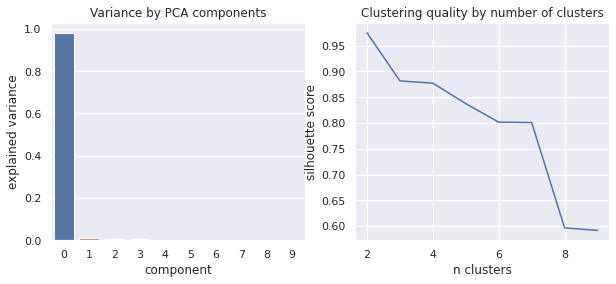

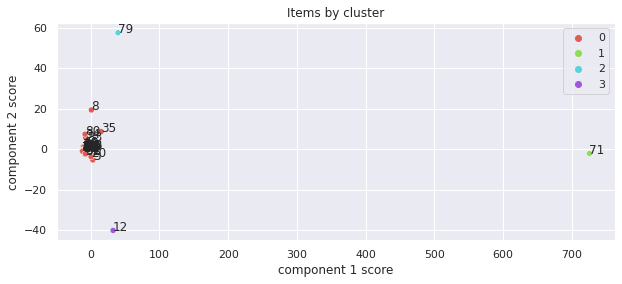

In [29]:
category_group_dict = cluster_feature( df, 'item_count_month', 'category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[], flag=1)
df['item_cluster'] = df['category_id'].map(category_group_dict)

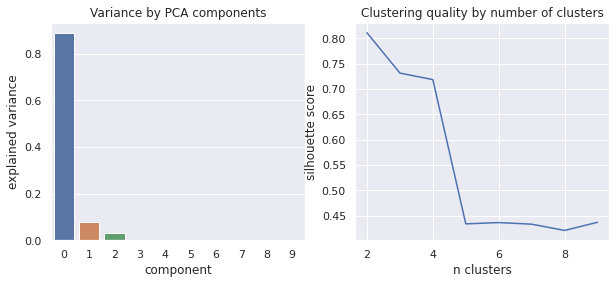

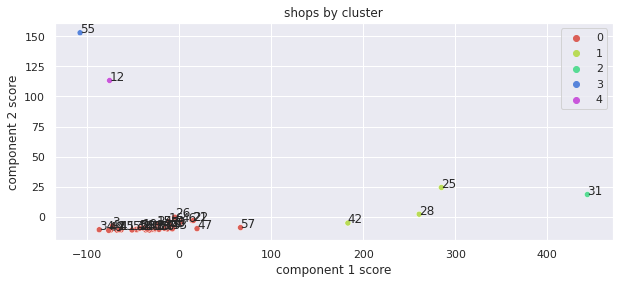

In [30]:
shop_group_dict = cluster_feature(df, 'item_count_month', 'shop_id', 'category_id', n_components=4, n_clusters=5, aggfunc="mean", exclude=[36], flag=2)
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
df['shop_cluster'] = df['shop_id'].map(shop_group_dict)

In [31]:
df['shop_cluster']=df['shop_cluster'].astype('int8')
df['item_cluster']=df['item_cluster'].astype('int8')
del df['item_count_month']

In [32]:
df.query("shop_id == 25")

,shop_id,item_id,date_block_num,month,year,day_quality,first_day_of_month,item_count,revenue,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster
111150,25,27,0,1,0,4.378974,1,0.0,0.0,0.0,19,34,27,2,8,25,0,1
111151,25,33,0,1,0,4.378974,1,5.0,2495.0,2.0,37,8,2,1203,5,26,0,1
111152,25,317,0,1,0,4.378974,1,1.0,299.0,4.0,45,91,66,52,4,158,0,1
111153,25,438,0,1,0,4.378974,1,0.0,0.0,0.0,45,79,57,57,4,221,0,1
111154,25,471,0,1,0,4.378974,1,1.0,399.0,3.0,49,70,39,51,4,240,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8570572,25,18454,34,11,2,4.257615,1035,0.0,0.0,0.0,55,13,10,9422,11,7840,0,1
8570573,25,16188,34,11,2,4.257615,1035,0.0,0.0,0.0,64,23,20,1597,9,6772,0,1
8570574,25,15757,34,11,2,4.257615,1035,0.0,0.0,0.0,55,32,29,7688,11,6606,0,1
8570575,25,19648,34,11,2,4.257615,1035,0.0,0.0,0.0,40,33,21,10823,5,8434,0,1


#### - shop이름에 관한 feature 추가

In [33]:
shops = pd.read_csv('/content/drive/MyDrive/input/shops.csv')
shops.dropna(inplace=True)

shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'
#shop_type이라는 column을 생성하여서 regular라는 값을 집어넣었다.

In [34]:
#9번과 20번은 각각 outbound trade, moscow sale이다. 
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special' 
 #12번과 55번 shopname에는 online이 있다. 
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'
#shop_name에 tc가 포함되면, shop_type에 tc가 저장된다.
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc' 
#러시아 어로, mail|center|mega는 쇼핑몰이다.
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall' 

shops['shop_city'] = shops[
    'shop_name'].str.split().str[0]
#shop_name의 첫단어를 shop_city라고 한다. 
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_type,shop_city
0,yakutsk ordzhonikidze 56 francs,0,2,29
1,yakutsk tc central fran,1,4,29
2,adygea tc mega,2,0,0
3,balashikha tc oktyabr kinomir,3,4,1
4,volga tc volga mall,4,0,26


In [35]:
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')

In [36]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categories, shops, temp, test, duplicated_items, item_map, category_group_dict, shop_group_dict
df.head()

,shop_id,item_id,date_block_num,month,year,day_quality,first_day_of_month,item_count,revenue,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster,shop_type,shop_city
0,2,27,0,1,0,4.381744,1,1.0,2499.0,2.0,19,34,27,2,8,25,0,0,0,0
1,2,33,0,1,0,4.381744,1,1.0,499.0,2.0,37,8,2,1203,5,26,0,0,0,0
2,2,317,0,1,0,4.381744,1,1.0,299.0,4.0,45,91,66,52,4,158,0,0,0,0
3,2,438,0,1,0,4.381744,1,1.0,299.0,19.0,45,79,57,57,4,221,0,0,0,0
4,2,471,0,1,0,4.381744,1,2.0,798.0,3.0,49,70,39,51,4,240,0,0,0,0


#### -  age & aggregated feature 추가

In [37]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')

df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

outlier로 인해 item_count의 평균이 이상해지는 것을 막기 위해 value를 clip

In [38]:
df['item_count_unclipped'] = df['item_count']
df['item_count'] = df['item_count'].clip(0, 20)

In [39]:
def downcast(df):
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

item/name/category/group/shop의 첫 등장 이후로 얼마나 지났는지 보여주는 age feature 추가

In [40]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
# add feature
#df["item_name_group_age"] = (df['date_block_num'] - df.groupby('item_name_group')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')
#df['shop_cluster_age'] = (df['date_block_num'] - df.groupby('shop_cluster')['date_block_num'].transform('min')).astype('int8')

In [41]:
#특정 상점에서 해당 상품을 언제 처음 팔았느냐
temp = df.query('item_count > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
#그리고 이를 item_shop_first_sale 이라고 다시 명시한다. 
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale'] 

df = pd.merge(df, temp, on=['item_id','shop_id'], how='left') 
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(40)

df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

다양한 그룹에 따라 평균 판매량을 구해주어 feature로 추가해준다.

In [42]:
def aggregate_counts(df, merging_cols, new_col, aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

In [43]:
df = aggregate_counts(df, ['date_block_num','shop_id'],'shop_count',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','shop_city'],'city_count',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','item_id'],'item_count_all_shops',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','category_id','shop_id'],'category_count',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','category_id'],'category_count_all_shops',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','group_id','shop_id'],'group_count',{'item_count':'mean'})
df = aggregate_counts(df, ['date_block_num','group_id'],'group_count_all_shops',{'item_count':'mean'})

In [44]:
df.sample(20)

,shop_id,item_id,date_block_num,month,year,day_quality,item_count,revenue,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_count_unclipped,item_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,shop_count,city_count,item_count_all_shops,category_count,category_count_all_shops,group_count,group_count_all_shops
4293847,52,2633,15,4,1,4.260393,0.0,0.0,280,58,34,25,3180,11,949,0,0,4,25,176,0.0,6,15,15,15,15,0,6,0.186675,0.208459,0.025000,0.023622,0.041535,0.122080,0.163904
2370138,41,2912,8,9,0,4.297239,0.0,0.0,240,25,37,31,3221,8,1030,0,0,0,17,4,0.0,1,1,8,8,8,0,1,0.250993,0.250993,0.054054,0.060000,0.252973,0.767442,0.856597
4255475,45,5459,15,4,1,4.241318,1.0,349.0,2,55,54,30,8215,11,1980,0,0,0,19,454,1.0,15,15,15,15,15,15,0,0.148990,0.178248,0.575000,0.141164,0.204364,0.103994,0.163904
2555531,19,12211,9,10,0,4.350541,0.0,0.0,2,62,17,16,5264,9,4982,0,0,4,10,272,0.0,9,9,9,9,9,9,0,0.309765,0.309765,0.027027,0.024000,0.172757,0.162928,0.234117
720229,47,18666,2,3,0,4.595783,0.0,0.0,14,55,32,22,1538,11,7925,0,0,0,22,46,0.0,2,2,2,2,2,0,2,0.249871,0.249871,0.027778,0.147736,0.226966,0.095408,0.179549
4943991,26,9175,18,7,1,4.399941,0.0,0.0,7,43,103,73,980,4,3493,0,0,2,11,540,0.0,18,18,18,18,18,18,0,0.219342,0.477216,0.048780,0.109677,0.094256,0.125000,0.126173
1903767,58,1011,6,7,0,4.375511,0.0,0.0,4,67,27,22,178,9,369,0,0,4,29,178,0.0,6,6,6,6,4,6,0,0.377837,0.532015,0.081081,0.126316,0.151067,0.265683,0.275888
5325949,58,868,19,8,1,4.494592,0.0,0.0,173,78,56,42,108,16,325,0,0,4,29,405,0.0,14,14,15,19,17,0,14,0.442001,0.523082,0.024390,0.000000,0.036856,0.141414,0.169377
4655712,18,1288,17,6,1,4.281053,0.0,0.0,501,40,39,27,638,5,482,0,0,4,9,16,0.0,1,17,17,17,17,0,1,0.194926,0.194926,0.800000,0.059568,0.236541,0.081867,0.196152
7313624,22,4088,28,5,2,4.376839,0.0,0.0,878,58,17,13,5739,11,1508,0,0,2,11,0,0.0,0,0,28,28,28,0,0,0.215146,0.503717,0.024390,0.093750,0.036204,0.087500,0.156449


카테고리별로 first month sale이 얼마나 되는지 나타내는 feature 추가 (신제품에 대한 예측을 할 때 도움이 될 것이라고 생각)

In [45]:
def new_item_sales(df, merging_cols, new_col):
    temp = (df[df['item_age']==0].groupby(merging_cols)['item_count'].mean().reset_index().rename(columns={'item_count': new_col}))
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

In [46]:
df = new_item_sales(df, ['date_block_num','category_id','shop_id'], 'new_items_in_cat')
df = new_item_sales(df, ['date_block_num','category_id'], 'new_items_in_cat_all_shops')

In [47]:
def aggregate_price(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'item_count_unclipped':'sum','revenue':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_count_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

In [48]:
df = aggregate_price(df,['date_block_num','item_id'],'item_price')
df = aggregate_price(df,['date_block_num','category_id'],'category_price')
df = aggregate_price(df,['date_block_num'],'block_price')

In [49]:
df.sample(20)

,shop_id,item_id,date_block_num,month,year,day_quality,item_count,revenue,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_count_unclipped,item_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,shop_count,city_count,item_count_all_shops,category_count,category_count_all_shops,group_count,group_count_all_shops,new_items_in_cat,new_items_in_cat_all_shops,item_price,category_price,block_price
2544253,16,2953,9,10,0,4.343436,0.0,0.0,1,21,55,40,3226,8,1046,0,0,4,8,273,0.0,9,9,9,9,9,0,9,0.215810,0.215810,0.027027,0.381818,0.399509,0.615523,0.729681,1.000000,1.081081,498.000000,659.874756,851.471313
6407353,25,7541,24,1,2,4.497935,0.0,0.0,541,31,51,37,11392,13,2767,0,1,2,11,190,0.0,7,7,20,24,24,0,7,1.013119,0.629701,0.048780,0.000000,0.099372,0.793872,0.459134,0.000000,0.119919,699.000000,418.759949,1073.768066
2137506,50,12919,7,8,0,4.475406,0.0,0.0,10,37,21,11,2763,5,5322,0,0,2,24,203,0.0,7,7,7,7,7,0,7,0.468102,0.468102,0.027027,0.268530,0.225247,0.329839,0.241030,0.320000,0.321081,149.000000,387.663208,602.185852
8117879,12,16494,32,9,2,4.447196,0.0,0.0,963,40,20,17,7721,5,6873,0,4,1,4,11,0.0,1,1,32,32,32,0,1,0.326220,0.326220,0.682927,0.025641,0.207161,0.160334,0.203444,0.045455,0.353659,169.000000,286.331665,1281.170410
1586444,53,11158,5,6,0,4.375010,0.0,0.0,2,40,23,11,9715,5,4452,0,0,4,25,150,0.0,5,5,5,5,5,0,5,0.250157,0.230823,0.027027,0.111361,0.236362,0.108929,0.225048,0.191919,0.791428,149.000000,262.103760,649.142639
8482843,53,7781,33,10,2,4.466695,0.0,0.0,627,31,54,38,11595,13,2829,0,0,4,25,377,0.0,13,13,29,33,33,0,13,0.191599,0.175062,0.023810,0.000000,0.081522,0.304260,0.341157,0.000000,0.087912,399.000000,757.038818,1225.512817
5826410,5,18022,22,11,1,4.405991,0.0,0.0,6,49,108,77,5196,4,7611,0,0,2,27,664,0.0,22,22,22,22,21,0,22,0.218478,0.218478,0.097561,0.011628,0.182360,0.012780,0.116185,0.000000,0.109756,500.000000,455.398132,1302.910767
7487865,12,3332,29,6,2,4.443299,1.0,599.0,283,22,34,26,3937,8,1181,0,4,1,4,599,1.0,20,20,29,29,29,20,0,0.268288,0.268288,0.024390,0.205882,0.350789,0.437168,0.507360,NaN,NaN,599.000000,1101.221924,1022.041687
8347560,18,1963,33,10,2,4.470925,0.0,0.0,995,30,43,32,1526,13,710,0,0,4,9,9,0.0,1,1,33,33,33,0,1,0.215738,0.215738,0.380952,0.423841,0.610533,0.263692,0.341157,0.000000,0.678571,599.000000,657.674866,1225.512817
3731577,41,9914,13,2,1,4.000000,0.0,0.0,45,37,49,26,6210,5,3841,0,0,0,17,352,0.0,12,13,13,13,13,12,0,0.229844,0.229844,0.052632,0.152500,0.161118,0.165428,0.218791,0.500000,0.824561,999.000000,416.855835,993.319336


In [50]:
df = downcast(df)

#### - Lagged feature 추가

In [51]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

3개의 lag feature
* lag1 전달의 value를 보여줌
* lag2 두달 전까지의 value를 보여줌
* lag1to6 6달전까지의 value들을 더함


In [52]:
lag6_cols = {
    'item_count':['date_block_num', 'shop_id', 'item_id'],
    'item_count_all_shops':['date_block_num', 'item_id'],
    'category_count':['date_block_num', 'shop_id', 'category_id'],
    'category_count_all_shops':['date_block_num', 'category_id'],
    'group_count':['date_block_num', 'shop_id', 'group_id'],
    'group_count_all_shops':['date_block_num', 'group_id'],
    'shop_count':['date_block_num', 'shop_id'],
    'city_count':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'category_id']
}
for col,merge_cols in lag6_cols.items():
    df[f'{col}_lag1to6'] = 0
    for i in range(1,7):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to6'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_count':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [53]:
df.sample(10)

,shop_id,item_id,date_block_num,month,year,day_quality,item_count,revenue,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_count_unclipped,item_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,item_price,category_price,block_price,item_count_lag1to6,item_count_all_shops_lag1to6,item_count_all_shops_lag1,item_count_all_shops_lag2,category_count_lag1to6,category_count_lag1,category_count_lag2,category_count_all_shops_lag1to6,category_count_all_shops_lag1,category_count_all_shops_lag2,group_count_lag1to6,group_count_lag1,group_count_lag2,group_count_all_shops_lag1to6,group_count_all_shops_lag1,group_count_all_shops_lag2,shop_count_lag1to6,shop_count_lag1,shop_count_lag2,city_count_lag1to6,city_count_lag1,city_count_lag2,new_items_in_cat_lag1to6,new_items_in_cat_lag1,new_items_in_cat_lag2,new_items_in_cat_all_shops_lag1to6,new_items_in_cat_all_shops_lag1,new_items_in_cat_all_shops_lag2
4291746,50,16152,15,4,1,4.240038,0.0,0.0,2,64,48,38,1596,9,6767,0,0,2,24,454,0.0,15,15,15,15,15,15,0,559.000000,991.333069,847.387695,2.0,0.767571,0.102564,0.052632,1.827164,0.324324,0.189189,2.474715,0.305960,0.331437,1.608262,0.266751,0.260274,1.905469,0.301112,0.315331,2.645555,0.420310,0.421781,1.907712,0.266469,0.261582,1.233333,0.666667,0.000000,1.824370,0.452991,0.217703
1019620,56,11675,3,4,0,4.211888,0.0,0.0,19,40,27,22,3893,5,4741,0,0,4,2,72,0.0,3,3,3,3,3,0,3,58.000000,273.524933,654.232300,0.0,0.460933,0.194444,0.205882,1.312165,0.426700,0.408837,0.861504,0.301542,0.268140,1.144767,0.366871,0.349653,0.806497,0.279056,0.253858,1.182801,0.394717,0.354616,1.182801,0.394717,0.354616,1.760853,0.740601,0.543624,1.331016,0.582916,0.456277
4311793,56,7056,15,4,1,4.217613,0.0,0.0,240,23,87,70,11008,8,2567,0,0,4,2,216,0.0,8,15,15,15,15,8,0,1818.914307,1465.836792,847.387695,2.0,2.955995,0.564103,0.631579,5.287312,0.649351,1.062500,5.264734,0.780220,0.974013,3.955287,0.534451,0.692446,4.846131,0.774006,0.818913,2.162237,0.320735,0.336342,2.162237,0.320735,0.336342,4.900000,0.900000,0.888889,5.244466,0.948718,1.046784
3644394,16,17479,13,2,1,4.000000,0.0,0.0,2,40,36,26,4219,5,7334,0,0,4,8,395,0.0,13,13,13,13,13,13,0,76.000000,273.061859,993.319336,0.0,0.890469,0.026316,0.026316,1.160271,0.183249,0.253915,1.615507,0.279564,0.319440,1.003089,0.159420,0.222928,1.464103,0.243766,0.290573,1.579579,0.253236,0.336919,1.579579,0.253236,0.336919,5.106247,0.279070,1.661290,7.722741,0.763770,1.973260
1357852,5,4723,5,6,0,4.405991,2.0,598.5,2,30,8,7,6392,13,1740,0,0,2,27,150,2.0,5,5,5,5,4,5,0,304.016144,509.497192,649.142639,8.0,8.761169,1.405405,1.277778,3.182757,0.867110,0.705167,5.903903,1.108647,1.084431,2.722110,0.503975,0.660592,5.684204,0.710738,1.053721,0.569740,0.143227,0.133017,0.569740,0.143227,0.133017,4.400182,2.076923,0.428571,8.845844,2.378378,1.488095
2865439,26,17540,10,11,0,4.338327,0.0,0.0,216,68,12,10,6059,9,7364,0,0,2,11,89,0.0,3,3,10,10,10,0,3,1858.333374,2462.692383,1087.465576,0.0,0.081081,0.054054,0.000000,0.000000,0.000000,0.000000,0.228657,0.033033,0.034749,1.090636,0.159386,0.167539,1.605325,0.234117,0.249752,1.678620,0.283643,0.313194,3.201910,0.538469,0.569785,0.000000,0.000000,0.000000,0.112613,0.000000,0.040541
539614,7,20227,2,3,0,4.526977,0.0,0.0,2,37,43,31,3884,5,8694,0,0,2,28,58,0.0,2,2,2,2,2,0,2,499.000000,507.849243,721.980591,0.0,0.121212,0.000000,0.121212,0.322163,0.137417,0.184746,0.420714,0.211726,0.208988,0.433325,0.203440,0.229885,0.527441,0.253858,0.273583,0.672759,0.337807,0.334953,0.831780,0.424021,0.407760,0.420040,0.235294,0.184746,0.518028,0.309040,0.208988
5407542,21,2244,20,9,1,4.241876,0.0,0.0,283,55,20,17,2823,11,826,0,0,0,11,326,0.0,11,11,20,20,20,11,0,299.000000,290.714172,1170.777344,8.0,4.269543,0.804878,0.439024,1.335931,0.208481,0.242492,1.430534,0.263840,0.249735,1.088617,0.173142,0.195738,1.148484,0.212137,0.200416,1.661

lag1과 lag2 feature

In [54]:
lag2_cols = {'item_count_unclipped':['date_block_num', 'shop_id', 'item_id']}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_count_unclipped':
        del df[col]

lag 1 feature 추가

In [55]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

lag1과 lag1to6의 비를 보여주는 feature

In [56]:
df['category_count_ratio'] = df['category_count_lag1']/df['category_count_lag1to6']
df['category_count_all_shops_ratio'] = df['category_count_all_shops_lag1']/df['category_count_all_shops_lag1to6']
df['item_count_ratio'] = df['item_count_unclipped_lag1']/df['item_count_lag1to6']
df['item_count_all_shops_ratio'] = df['item_count_all_shops_lag1']/df['item_count_all_shops_lag1to6']

missing value 0으로 처리

In [57]:
df.loc[(df['item_age']>0) & (df['item_count_lag1to6'].isna()), 'item_count_lag1to6'] = 0
df.loc[(df['category_age']>0) & (df['category_count_lag1to6'].isna()), 'category_count_lag1to6'] = 0
df.loc[(df['group_age']>0) & (df['group_count_lag1to6'].isna()), 'group_count_lag1to6'] = 0

lag를 normalize 한다

In [58]:
df['item_count_lag1to6'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[6]*len(df))]
df['item_count_all_shops_lag1to6'] /= [min(idx) for idx in zip(df['item_age'],[6]*len(df))]
df['category_count_lag1to6'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[6]*len(df))]
df['category_count_all_shops_lag1to6'] /= [min(idx) for idx in zip(df['category_age'],[6]*len(df))]
df['group_count_lag1to6'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[6]*len(df))]
df['group_count_all_shops_lag1to6'] /= [min(idx) for idx in zip(df['group_age'],[6]*len(df))]
df['city_count_lag1to6'] /= [min(idx) for idx in zip(df['date_block_num'],[6]*len(df))]
df['shop_count_lag1to6'] /= [min(idx) for idx in zip(df['shop_age'],[6]*len(df))]
df['new_items_in_cat_lag1to6'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[6]*len(df))]
df['new_items_in_cat_all_shops_lag1to6'] /= [min(idx) for idx in zip(df['category_age'],[6]*len(df))]

In [59]:
df = downcast(df)

past information을 담고있는 추가적인 feature 생성
- 특정 item의 최종 가격
- 특정 shop에서 특정 item이 팔린 총량
- 특정 item의 총 판매량

In [60]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

In [61]:
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
df = past_information(df, ['shop_id','item_id'],'item_count_sum_alltime',{'item_count':'sum'})
df = past_information(df, ['item_id'],'item_count_sum_alltime_allshops',{'item_count':'sum'})
del df['revenue'], df['item_count_unclipped'], df['item_price']

판매 기간동안 평균적인 판매 개수와 가격의 변동을 나타내주는 feature 추가

In [62]:
df['item_count_per_day_alltime'] = (df['item_count_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']
df['item_count_per_day_alltime_allshops'] = (df['item_count_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [63]:
import gc
gc.collect()
df = downcast(df)

앞의 글자가 같은 상품들의 mean sales를 계산 (신제품 등장 시 유추할 수 있도록)

In [64]:
for all_shops in [True, False]:
    temp_cols = ['same_name11catage_cnt','date_block_num', 'item_name_first11','item_age','category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_count':'mean'})
            .reset_index()
            .rename(columns={'item_count':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')

In [65]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_count','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','category_id',
    'item_age',
]
int16_cols = [
    #'item_id','item_name_first4','item_name_first6',
    'item_name_first11', 'item_name_len', 
    'item_name_cleaned_len', 
    'item_name_group'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

근접한 아이템들은 유사 아이템인 경우가 많기 때문에, 근접한 item의 정보를 feature로 select

In [66]:
def nearby_item_data(df,col):
    if col in ['item_count_unclipped_lag1','item_count_lag1to6']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_count_unclipped_lag1','item_count_lag1to6','item_count_all_shops_lag1','item_count_all_shops_lag1to6']
for col in item_cols:
    df = nearby_item_data(df,col)

del temp

In [67]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)

item_name_first11을 binary encoding => high cardinality

In [68]:
df.sample(20)

,shop_id,item_id,date_block_num,month,year,day_quality,item_count,first_sale_day,category_id,item_name_len,item_name_cleaned_len,item_name_first11,group_id,item_name_group,item_cluster,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,item_count_lag1to6,item_count_all_shops_lag1to6,item_count_all_shops_lag1,item_count_all_shops_lag2,category_count_lag1to6,category_count_lag1,category_count_lag2,category_count_all_shops_lag1to6,category_count_all_shops_lag1,category_count_all_shops_lag2,group_count_lag1to6,group_count_lag1,group_count_lag2,group_count_all_shops_lag1to6,...,new_items_in_cat_all_shops_lag1,new_items_in_cat_all_shops_lag2,item_count_unclipped_lag1,item_count_unclipped_lag2,category_price_lag1,block_price_lag1,category_count_ratio,category_count_all_shops_ratio,item_count_ratio,item_count_all_shops_ratio,last_item_price,item_count_sum_alltime,item_count_sum_alltime_allshops,item_count_per_day_alltime,relative_price_item_block_lag1,item_count_per_day_alltime_allshops,same_name11catage_cnt_all_shops,same_name11catage_cnt,below_item_count_unclipped_lag1,above_item_count_unclipped_lag1,below_item_count_lag1to6,above_item_count_lag1to6,below_item_count_all_shops_lag1,above_item_count_all_shops_lag1,below_item_count_all_shops_lag1to6,above_item_count_all_shops_lag1to6,item_name_first11_1,item_name_first11_2,item_name_first11_3,item_name_first11_4,item_name_first11_5,item_name_first11_6,item_name_first11_7,item_name_first11_8,item_name_first11_9,item_name_first11_10,item_name_first11_11,item_name_first11_12,item_name_first11_13,item_name_first11_14
8018377,45,10253,31,8,2,4.491347,0,242,70,44,28,11616,9,4013,0,0,0,19,701,24,24,31,31,31,0,24,0.000000,0.020427,0.024390,0.048780,0.290375,0.386364,0.379310,0.472074,0.449279,0.519764,0.151580,0.206621,0.131673,0.276978,...,0.121951,0.560976,1.0,1.0,410.075073,941.071228,0.221761,0.158619,inf,0.199005,299.000000,NaN,170.0,0.000000,0.317723,0.242511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0,1,1,1,0,1,1,1,1,1
122274,26,18271,0,1,0,4.399941,0,4,55,20,16,9436,11,7742,0,0,2,11,0,0,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,0,0,1,0,1,0,1,0,1,1,1,1,1,1
5077617,58,8597,18,7,1,4.381628,0,4,55,31,28,982,11,3226,0,0,4,29,543,18,18,18,18,16,18,0,0.000000,0.094293,0.075000,0.050000,0.223027,0.278889,0.223005,0.221971,0.242333,0.230546,0.156763,0.197327,0.157765,0.177466,...,0.539516,0.588095,1.0,1.0,289.468292,848.428467,0.208411,0.181956,inf,0.132566,199.000000,5.0,92.0,0.009208,0.234551,0.169429,NaN,NaN,1.0,1.0,0.00,0.333333,0.075000,0.075000,0.087981,0.089676,0,1,0,0,0,1,0,0,0,0,1,0,0,0
5383711,14,17605,20,9,1,4.241509,0,613,31,44,33,8103,13,7396,0,0,4,6,0,0,0,16,20,20,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.064947,0.072613,0.065341,0.535577,0.511745,0.384615,0.634205,...,0.101865,0.080740,0.0,0.0,486.226471,876.206299,NaN,0.186338,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,0,1,0,0,1,0,1,0,1
5689029,34,6760,21,10,1,4.401953,0,243,31,45,34,10545,13,2457,0,0,2,13,396,14,14,17,21,3,0,14,0.000000,0.020630,0.000000,0.000000,0.000000,0.000000,0.000000,0.066687,0.072936,0.072613,0.100207,0.146259,0.154362,0.610916,...,0.094994,0.101865,0.0,0.0,705.432617,1170.777344,NaN,0.182286,NaN,0.000000,445.000000,NaN,12.0,0.000000,0.380089,0.030303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,0,0,0,1,0,1,0,1,1
1092974,7,10087,4,5,0,4.373468,0,140,40,29,22,3649,5,3933,0,0,2,28,0,0,4,4,4,4,0,0,NaN,NaN,0.000000,0.000000,0.192384,0.148014,0.166455,0.277415,0.248157,0.301542,0.183987,0.137899,0.164724,0.260072,...,0.858992,0.582916,1.0,1.0,273.524933,654.232300,0.192343,0.223633,inf,NaN,NaN,NaN,NaN,0.000000,NaN

In [69]:
#save dataframe for later use
df.to_pickle('/content/drive/MyDrive/df_complete_final.pkl')

In [70]:
#Reset the kernel to clear memory.
%reset -f

# 2. 모델링

In [3]:
!pip install lightgbm

In [4]:
!pip install shap

In [5]:
!pip install plotly

In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

Train, Validation, Test set 생성
* train은 앞에 두 month와 마지막 두 month를 제외
* validation은 test 전달
* test는 34번째 month

In [7]:
#load the saved training dataframe
df = pd.read_pickle('/content/drive/MyDrive/df_complete_fin.pkl')

In [8]:
df.shape

(8723577, 92)

In [10]:
X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_count']
del X_train['item_count']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_count']
del X_val['item_count']

X_test = df[df['date_block_num']==34].drop(columns='item_count')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

**1) LGBM모델 트레이닝** <br>

Optuna로 best params를 선정하였다.

In [9]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [79]:
#skip this cell if directly loading saved model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1,
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

#save model for later use
lgb_model.save_model('/content/drive/MyDrive/model.txt')

Training until validation scores don't improve for 30 rounds.
[50]	training's rmse: 0.980475	valid_1's rmse: 0.898462
[100]	training's rmse: 0.840822	valid_1's rmse: 0.814811
[150]	training's rmse: 0.7668	valid_1's rmse: 0.780242
[200]	training's rmse: 0.724459	valid_1's rmse: 0.765994
[250]	training's rmse: 0.697199	valid_1's rmse: 0.75919
[300]	training's rmse: 0.67677	valid_1's rmse: 0.755764
[350]	training's rmse: 0.660956	valid_1's rmse: 0.753772
[400]	training's rmse: 0.647907	valid_1's rmse: 0.753281
Early stopping, best iteration is:
[418]	training's rmse: 0.643802	valid_1's rmse: 0.752943


저장된 모델 불러와서 사용하기

In [8]:
lgb_model = lgb.Booster(model_file='/content/drive/MyDrive/model.txt')
lgb_model.params['objective'] = 'rmse'

제출 데이터 생성

In [9]:
submission = pd.read_csv('/content/drive/MyDrive/input/test.csv')
#submission['item_count_month'] = lgb_model.predict(X_test).clip(0,20)
X_test['lgb_pred'] = lgb_model.predict(X_test).clip(0,20)
submission['item_cnt_month'] =X_test['lgb_pred']
submission[['ID', 'item_cnt_month']].to_csv('/content/drive/MyDrive/lgb_submission.csv', index=False)

**2) XGB모델 트레이닝** <br>


In [11]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 20)

[18:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:49:21] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/input/test.csv')
X_test['lgb_pred'] = model.predict(X_test).clip(0,20)
submission['item_cnt_month'] =X_test['lgb_pred']
submission[['ID', 'item_cnt_month']].to_csv('/content/drive/MyDrive/xgb_submission.csv', index=False)

model.save_model("XGBmodel.txt")

**3) CATBoost모델 트레이닝** <br>


In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
model_catboost = CatBoostRegressor(verbose=False, random_seed=566)


model_catboost.fit(X_train,y_train);
prediction_catboost = model_catboost.predict(X_val)
print(mean_squared_error(y_val, prediction_catboost, squared=False))


prediction = model_catboost.predict(X_test)
prdiction_catboost = prediction

submission = pd.DataFrame({
    "ID": np.arange(prediction.shape[0]), 
    "item_cnt_month": prediction.clip(0, 20)
})
submission.to_csv('/content/drive/MyDrive/cat_submission.csv', index=False)

model_catboost.save_model("CATmodel.txt")

### Weighted Average for final prediction

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/lgb_submission.csv')
df2 = pd.read_csv('/content/drive/MyDrive/cat_submission.csv.csv')
df3 = pd.read_csv('/content/drive/MyDrive/xgb_submission.csv.csv')

x1 = 0.7
dfY = df2.copy()
k = 'item_cnt_month'
dfY[k] = x1*df2[k] + (1.0-x1)*df3[k]

x1 = 0.68
dfX = df1.copy()
k = 'item_cnt_month'
dfX[k] = x1*df1[k] + (1.0-x1)*dfY[k]
dfX.to_csv('/content/drive/MyDrive/weighted_submission.csv', index=False)